In [1]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 15.3 MB/s eta 0:00:00


In [2]:
import torch
import torch_geometric
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import to_dense_adj
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random


print('libraries are imported successfuly')

libraries are imported successfuly


In [3]:
def set_random_seed(seed=42):
    """
    Set the random seed for reproducibility.
    """
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)




def load_cora_subset(n=32):
    """
    Loads the Cora dataset and returns the normalized adjacency matrix for the first `n` nodes.
    Args:
        n (int): Number of nodes to select for the subgraph.
    Returns:
        numpy.ndarray: Normalized adjacency matrix of the subgraph.
    """

    dataset = Planetoid(root='/tmp/Cora', name='Cora')
    data = dataset[0]

    edge_index = data.edge_index
    num_nodes = data.num_nodes

    if n > num_nodes:
        raise ValueError(f"n={n} exceeds the total number of nodes in Cora ({num_nodes}).")


    A = to_dense_adj(edge_index, max_num_nodes=n).squeeze(0)


    A = A + torch.eye(A.shape[0])


    D_inv_sqrt = torch.diag(1.0 / torch.sqrt(A.sum(dim=1)))
    A_norm = D_inv_sqrt @ A @ D_inv_sqrt

    return A_norm.numpy()



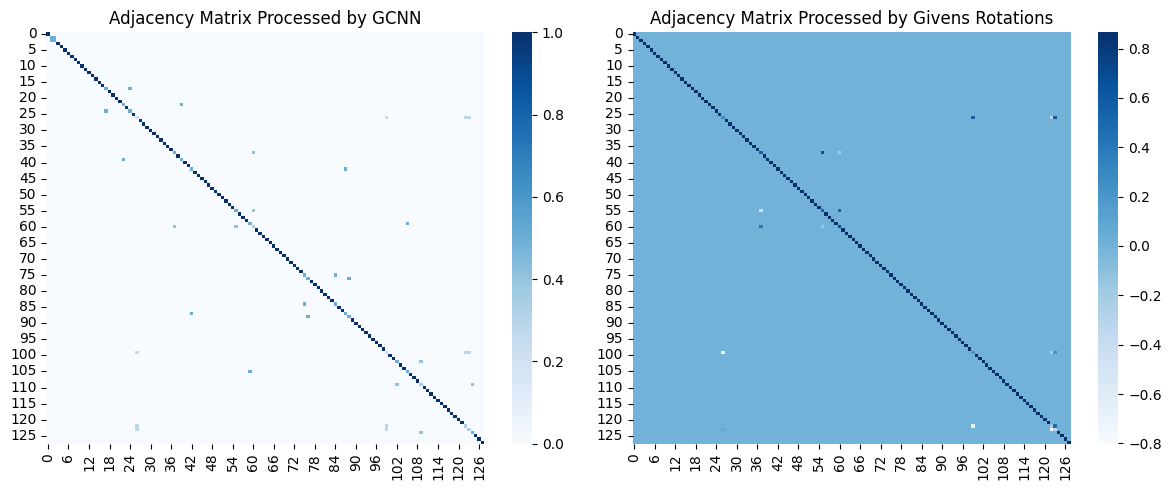

In [37]:
def givens_rotation(n, i, j, theta):
    """
    Constructs an n×n Givens rotation matrix that rotates in the (i,j) plane by angle theta.
    """
    G = np.eye(n)
    c, s = np.cos(theta/2), np.sin(theta/2)


    G[i, i], G[j, j] = c, c
    G[i, j], G[j, i] = -s, s

    return G


def construct_unitary_from_graph(adj_matrix, theta):
    """
    Constructs the final unitary matrix using Givens rotations where adj_matrix[i, j] = 1.
    """
    n = adj_matrix.shape[0]
    U = np.eye(n)

    for i in range(n):
        for j in range(n):
            if adj_matrix[i, j] != 0:
                G = givens_rotation(n, i, j, theta)
                U = G @ U

    return U


def plot_heatmaps(original, transformed):
    """
    Plots the heatmaps of the original adjacency matrix and the transformed matrix.
    """
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    sns.heatmap(original, cmap="Blues", ax=axes[0])
    axes[0].set_title("Adjacency Matrix Processed by GCNN")

    sns.heatmap(transformed, cmap="Blues", ax=axes[1])
    axes[1].set_title("Adjacency Matrix Processed by Givens Rotations")

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":

    set_random_seed(seed=42)
    adj_matrix = load_cora_subset(n=128)
    theta_fixed = np.pi/1.5
    U = construct_unitary_from_graph(adj_matrix, theta_fixed)
    plot_heatmaps(adj_matrix, U)
